# Exploratory Data Analysis

---

This few-shot benchmark tests various meta-learning methods in the context of
biomedical applications. In particular, we are dealing with the [Tabula Muris]()
and [SwissProt]() datasets. One is a cell type classification task based on
single-cell gene expressions and the other is a protein function prediction task
based on protein sequences. The goal of this notebook is to explore basic
statistics about the two datasets, as well as understand how the data loading is
implemented for the episodic training during meta-training.


## Setup

---

First, let's import the relevant modules needed.


In [1]:
# ruff: noqa: E402
# Reload modules automatically
%reload_ext autoreload
%autoreload 2

# Module imports
import sys
import time
from collections import Counter

# External imports
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import pandas as pd
import torch

In [2]:
# Add path to load local modules
sys.path.append("..")

# Set styles
sns.set_style("dark")
colorstyle = "RdBu"
sns.set_palette(colorstyle)

## Base Classes

---

Both datasets are implemented as subclasses of the `FewShotDataset` class and
use some other generic utility classes. We will explore these here in detail.
They are all defined in the `datasets.dataset` module.


### FewShotDataset

The `FewShotDataset(torch.utils.data.Dataset)` is the base class for all
few-shot datasets. It implements the `__getitem__` and `__len__` methods and has
some utilities for checking the data validty. Furthermore, it is responsible for
loading and extracting the dataset into the `root` directory if specified and
not yet existent. However, as it is a abstract base class, it cannot be
instantiated, e.g. it requires the `_dataset_name` and `_dataset_dir` as class
attributes.


In [3]:
# Demo: FewShotDataset
from datasets.dataset import FewShotDataset  # noqa

try:
    few_shot_dataset = FewShotDataset()
except Exception as e:
    print(f"❌ Fails with error {e}.")

❌ Fails with error FewShotDataset must have attribute _dataset_name..


In [4]:
# Demo FewShotSubDataset
from datasets.dataset import FewShotSubDataset  # noqa

# Create a random dataset with 100 samples, 5 features and 5 classes
samples = torch.rand(100, 5)
targets = torch.randint(0, 5, (100,))  # 5-way
subset_target = 4

# Get all samples that belong to class 4
subset_samples = samples[targets == subset_target]

# Create a few-shot dataset for class 4
few_shot_sub_dataset = FewShotSubDataset(subset_samples, subset_target)

# Sanity checks
assert (
    len(few_shot_sub_dataset) == (targets == subset_target).sum()
), "❌ Length of few-shot dataset is not correct."
assert (
    few_shot_sub_dataset.dim == samples.shape[1]
), "❌ Dimension of few-shot dataset is not correct."

### Episodic Batch Sampler

The `EpisodicBatchSampler` is a utility class that randomly samples `n_way`
classes (out of a total of `n_classes`) for a total of `n_episodes`. It can be
used in episodic training to sample the classes used in each episode.

The sampler is `n_episodes` long and each time samples randomly (without
replacement) from `{0, ..., n_classes-1}` `n_way` times.


In [5]:
# Demo: EpisodicBatchSampler
from datasets.dataset import EpisodicBatchSampler  # noqa

# Demo of EpisodicBatchSampler
n_episodes, n_way, n_classes = 3, 5, 10
episodic_batch_sampler = EpisodicBatchSampler(n_classes, n_way, n_episodes)

print(f"Episodes: {n_episodes}, Ways: {n_way}, Classes: {n_classes}")
for batch_idx, indices in enumerate(episodic_batch_sampler):
    print(f"Episode {batch_idx+1} w/ classes {indices.numpy()}")

Episodes: 3, Ways: 5, Classes: 10
Episode 1 w/ classes [9 1 8 3 6]
Episode 2 w/ classes [0 3 9 4 8]
Episode 3 w/ classes [7 5 3 6 0]


## Tabula Muris

---

**Tabula Muris** is a dataset of single cell transcriptome data (gene
expressions) from mice, containing nearly `100,000` cells from `20` organs and
tissues. The data allow for direct and controlled comparison of gene expression
in cell types shared between tissues, such as immune cells from distinct
anatomical locations.

_More Resources_:

- [Tabular Muris Website](https://tabula-muris.ds.czbiohub.org/)
- [SF Biohub Article](https://www.czbiohub.org/sf/tabula-muris/)


In [6]:
!du -sh ../data/tabula_muris/*

 84M	../data/tabula_muris/gene_association.mgi
 32M	../data/tabula_muris/go-basic.obo
3.2G	../data/tabula_muris/processed
2.3G	../data/tabula_muris/tabula-muris-comet.h5ad


In [7]:
!du -sh ../data/tabula_muris/processed/*

4.0K	../data/tabula_muris/processed/mapping.pkl
3.2G	../data/tabula_muris/processed/tabula-muris.pkl


### TMSimpleDataset

The `TMSimpleDataset` is a simple dataset class that is designed for regular
multi-class classification training/ fine-tuning. It loads the entire
(processed) dataset into memory and wraps inside a PyTorch Dataset object.
Supports functionality for retrieving a single sample, a batched data loader and
the dimensionality of the data.

_Note: Upon first call, the `TMSimpleDataset` class will download the data into
the `root` directory._


In [8]:
# Demo: TMSimpleDataset
from datasets.cell.tabula_muris import TMSimpleDataset  # noqa

# Arguments to provide
batch_size = 10
root = "../data"
min_samples = 1
subset = 1.0

kwargs = {
    "batch_size": batch_size,
    "root": root,
    "min_samples": min_samples,
    "subset": subset,
}

# Controls data split (returns subset of tissue types)
modes = ["train", "val", "test"]

# Initialise TabulaMuris training dataset
data = {}
for mode in modes:
    start = time.time()
    data[mode] = TMSimpleDataset(**kwargs, mode=mode)
    loading_time = time.time() - start
    print(f"✅ Tabula Muris {mode} split loaded in {loading_time:.2f} seconds.")

✅ Tabula Muris train split loaded in 5.09 seconds.
✅ Tabula Muris val split loaded in 2.29 seconds.
✅ Tabula Muris test split loaded in 3.83 seconds.


**Sample loading.** Let's first look at the samples and their features. We can
obtain a single sample using indexing into the data. We will plot the
dimensionality of each sample and hope to see the same number of features for
each sample.


In [9]:
# Get sample from each split
train_x, train_y = data["train"][0]
val_x, val_y = data["val"][0]
test_x, test_y = data["test"][0]

# Print sample shapes
print(f"ℹ️ Train sample has shape {train_x.shape} and cell type {train_y}.")
print(f"ℹ️ Val sample has shape {val_x.shape} and cell type {val_y}.")
print(f"ℹ️ Test sample has shape {test_x.shape} and cell type {test_y}.")

ℹ️ Train sample has shape (2866,) and cell type 37.
ℹ️ Val sample has shape (2866,) and cell type 21.
ℹ️ Test sample has shape (2866,) and cell type 87.


**Batch Loading.** We can use the `.get_data_loader()` method to get a data
loader for each split. This is useful for training and evaluation. The batch
size was specified during initialisation of the dataset class. Furthermore, one
can change the number of workers used for loading the data.

_NB: We only show the first batch of the training data loader._


In [10]:
# Get data loader
train_loader = data["train"].get_data_loader(num_workers=0, pin_memory=False)

# Get batch
tr_smps, tr_trgs = next(iter(train_loader))

print(f"Training batch shape: {tr_smps.shape} and target {tr_trgs.shape}")
print(f"Targets:\n{tr_trgs}")

Training batch shape: torch.Size([10, 2866]) and target torch.Size([10])
Targets:
tensor([18, 56,  4,  0, 26, 81, 25, 95, 84, 84])


### TMSetDataset

The `TMSetDataset` is designed for few-shot learning. Most configurations are
the same as for the `TMSimpleDataset`, but crucially the dataset class will
return an episodic batch sampler based on the `n_way`, `n_support`, `n_query`
and parameters.


In [11]:
# Demo: TMSetDataset
from datasets.cell.tabula_muris import TMSetDataset  # noqa

# Arguments to provide
root = "../data"
n_way = 5
n_support = 5
n_query = 5

kwargs = {
    "n_way": n_way,
    "n_support": n_support,
    "n_query": n_query,
    "root": root,
}

# Controls data split (returns subset of tissue types)
modes = ["train", "val", "test"]

data = {}
for mode in modes:
    start = time.time()
    data[mode] = TMSetDataset(**kwargs, mode=mode)
    loading_time = time.time() - start
    print(f"✅ TMSetDataset {mode} split loaded in {loading_time:.2f} seconds.")

✅ TMSetDataset train split loaded in 6.14 seconds.
✅ TMSetDataset val split loaded in 2.77 seconds.
✅ TMSetDataset test split loaded in 4.20 seconds.


In a few-shot learning dataset, a sample is an episode for a single class
consisting of a support set of `n_support` samples and a query set of `n_query`
samples. Thus, the `__getitem__` method returns a tuple of the support and query
samples and targets for the `i`-th class. Thus, the returned tensor dimension
will be `(n_support + n_query, n_features)` for the samples and
`(n_support + n_query, )` for the targets.


In [12]:
# Get sample by indexing
tr_smp, tr_trg = data["train"][0]

# Support samples and target
sup_tr_smp, sup_tr_trg = tr_smp[:n_support], tr_trg[:n_support]

# Query samples and target
que_tr_smp, que_tr_trg = tr_smp[n_support:], tr_trg[n_support:]

print(f"Training samples shape: {tr_smp.shape} and target {tr_trg}")
print(f"Support samples shape: {sup_tr_smp.shape} and target {sup_tr_trg}")
print(f"Query samples shape: {sup_tr_smp.shape} and target {sup_tr_trg}")

Training samples shape: torch.Size([10, 2866]) and target tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Support samples shape: torch.Size([5, 2866]) and target tensor([0, 0, 0, 0, 0])
Query samples shape: torch.Size([5, 2866]) and target tensor([0, 0, 0, 0, 0])


Next, the data loader class combines the support-query sampler per class (as
defined above) and the `EpisodicBatchSampler` to create a data loader that
returns batches of episodes where each time we get `n_way` classes with
`n_support` support samples and `n_query` query samples per class. First, the
episodic batch sample samples the `n_way` random class indices and then the
support-query sampler samples the support and query samples for each class.
Thus, the final tensor shapes will be `(n_way, n_query + n_support, n_features)`
for the samples and `(n_way, n_query + n_support, )` for the targets.


In [13]:
# Get data loader
train_loader = data["train"].get_data_loader(num_workers=0, pin_memory=False)

# Get batch
tr_smps, tr_trgs = next(iter(train_loader))

print(f"Training batch shape: {tr_smps.shape} and target {tr_trgs.shape}")
print(f"Targets:\n{tr_trgs}")

Training batch shape: torch.Size([5, 10, 2866]) and target torch.Size([5, 10])
Targets:
tensor([[ 42,  42,  42,  42,  42,  42,  42,  42,  42,  42],
        [ 83,  83,  83,  83,  83,  83,  83,  83,  83,  83],
        [114, 114, 114, 114, 114, 114, 114, 114, 114, 114],
        [ 37,  37,  37,  37,  37,  37,  37,  37,  37,  37],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])


**NB 1:** Shuffling in meta-learning tasks is not necessary because the episodic
batch sampler and the sub-class sampler are already random.


### EDA

In this section we will explore the data in more detail. We will look at the raw
and processed data. In particular:

- Total number of samples (cells) and targets (cell types) in processed data
  (after filtering, but given `min_samples=1`)
- Feature distributions for processed data (gene expressions)
- Target overlap between meta-splits
- Target distributions across meta-splits

Let's reload the data through the simple dataset class.


In [14]:
# Load all data splits (we will use this for the rest of the notebook)
train_data = TMSimpleDataset(root="../data", batch_size=1, mode="train")
val_data = TMSimpleDataset(root="../data", batch_size=1, mode="val")
test_data = TMSimpleDataset(root="../data", batch_size=1, mode="test")

**Number of samples.** Let's compute the number of samples in the processed
meta-splits. Note, that we are using all cells that are in a specific tissue and
that were not filtered out through pre-processin. Since we have set
`min_samples=1`, we are not ignoring any cells of cell types that are
underrepresented in the data.


In [15]:
# Print number of samples in each split
num_train_samples = len(train_data)
num_val_samples = len(val_data)
num_test_samples = len(test_data)
total_samples = num_train_samples + num_val_samples + num_test_samples

print(
    f"ℹ️ Train Samples: {num_train_samples} ({(100 * num_train_samples / total_samples):.1f}%)"
)
print(
    f"ℹ️ Val Samples: {num_val_samples} ({(100 * num_val_samples / total_samples):.1f}%)"
)
print(
    f"ℹ️ Test Samples: {num_test_samples} ({(100 * num_test_samples / total_samples):.1f}%)"
)

ℹ️ Train Samples: 65846 (62.1%)
ℹ️ Val Samples: 15031 (14.2%)
ℹ️ Test Samples: 25083 (23.7%)


**Number of targets.** Next, let's get an idea of the number of targets in the
processed meta-splits.


In [16]:
# Print number of targets (cell types) in each split
train_targets = set(np.unique(train_data.targets))
val_targets = set(np.unique(val_data.targets))
test_targets = set(np.unique(test_data.targets))
total_targets = train_targets | val_targets | test_targets

print(
    f"ℹ️ Train targets: {len(train_targets)} ({(100 * len(train_targets) / len(total_targets)):.1f}%)"
)
print(
    f"ℹ️ Val targets: {len(val_targets)} ({(100 * len(val_targets) / len(total_targets)):.1f}%)"
)
print(
    f"ℹ️ Test targets: {len(test_targets)} ({(100 * len(test_targets) / len(total_targets)):.1f}%)"
)

ℹ️ Train targets: 59 (47.6%)
ℹ️ Val targets: 47 (37.9%)
ℹ️ Test targets: 37 (29.8%)


**Target overlap.** Typically, in few-shot learning the meta-train/ meta-val and
meta-test split should not have any overlap in the targets. We wish to simulate
the scenario of observing a completely new set of classes, i.e. cell types,
during meta-test and use a model that was trained on other classes during
meta-train. Let's check if this is the case for the Tabula Muris dataset.


In [17]:
# Target overlap
general_overlap = train_targets & val_targets & test_targets
train_val_overlap = train_targets & val_targets
train_test_overlap = train_targets & test_targets

print(f"ℹ️ All overlap: {len(general_overlap)} {general_overlap}")
print(f"ℹ️ Train-Val overlap: {len(train_val_overlap)} {train_val_overlap}")
print(f"ℹ️ Train-Test overlap: {len(train_test_overlap)} {train_test_overlap}")

ℹ️ All overlap: 2 {36, 14}
ℹ️ Train-Val overlap: 13 {0, 3, 4, 36, 74, 75, 44, 14, 15, 50, 51, 93, 30}
ℹ️ Train-Test overlap: 4 {54, 36, 61, 14}


There is overlap between the targets in the meta-train and meta-val split, as
well as the meta-train and meta-test split. This is the result on splitting on
the tissue types. We are trying to do transfer learning from one tissue to
another and for some cell types we are lucky and they are present in tissues
that we have seen during meta-train. However, the overlap is not huge. Let's try
to understand the relationship between tissues and cell types in more detail by
plotting the co-occurence matrix of tissues and cell types.


In [18]:
# Pivot to get cooccurence matrix of tissue and cell type
def tissue_cell_type_cooccurrence(data, ax):
    tmp = data.data.obs.pivot_table(
        index="tissue",
        columns="cell_ontology_class_reannotated",
        values="label",
        aggfunc="count",
        fill_value=0,
    )

    # Row normalise
    tmp = tmp.div(tmp.sum(axis=1), axis=0)
    sns.heatmap(tmp, ax=ax)
    ax.set(xlabel="Cell Ontology Class", ylabel="Tissue")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

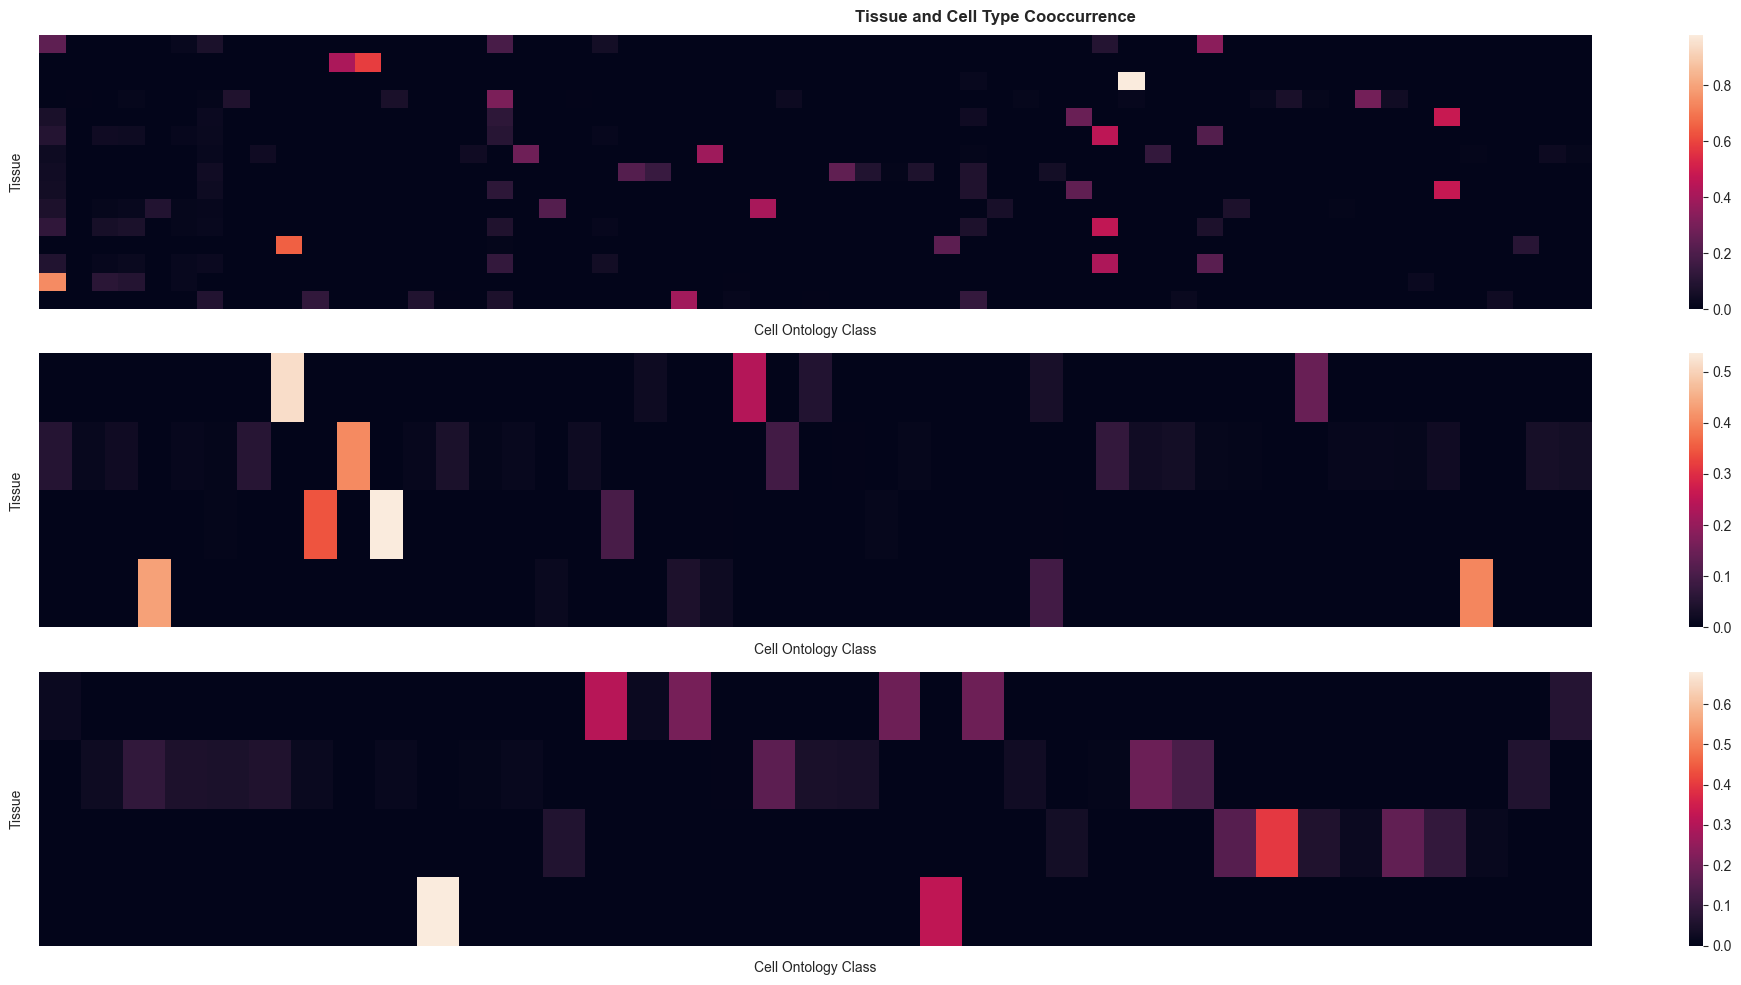

In [19]:
# Plot cooccurrence matrix of tissue and cell type
fig, ax = plt.subplots(nrows=3, figsize=(20, 10))
fig.suptitle("Tissue and Cell Type Cooccurrence", fontweight="bold")
tissue_cell_type_cooccurrence(train_data, ax[0])
tissue_cell_type_cooccurrence(val_data, ax[1])
tissue_cell_type_cooccurrence(test_data, ax[2])

fig.tight_layout()

As suspected, cell types are often very tightly coupled with tissue types. Thus,
splitting on tissue types for a few-shot learning task means to a large extent
splitting on cell types as well. For good measure, let's also plot the target
distribution of the cell types in the train, val and test split.


**Feature distributions.** We will investigate the features (data types, number
of missing values and distributions) of the processed data. For convenience, we
will load the feature matrix into a dataframe.


In [20]:
df_train_data = pd.DataFrame(
    train_data.samples,
    index=train_data.data.obs.index,
    columns=train_data.data.var.index,
)

df_train_data.head(5)

index,0610010O12Rik,0610011F06Rik,0610040J01Rik,1100001G20Rik,1110002N22Rik,1110012J17Rik,1110018G07Rik,1110032A04Rik,1110037F02Rik,1190002H23Rik,...,Zfr2,Zfyve28,Zg16,Zic2,Zkscan5,Zmiz1,Zranb1,Zscan20,Zufsp,Zxdb
index,,,,,,,,,,,,,,,,,,,,,
F11_B003857_S143_L004.mus-2-0-1,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,-0.489169,-0.331498,-0.075302,-0.290914,-0.113769
D19.B002433.3_38_F.1.1-1-1,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,0.812573,-0.422841,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,-0.489169,-0.259448,-0.075302,-0.290914,-0.113769
F8.B003279.3_38_F.1.1-1-1,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841,...,-0.110849,-0.083278,-0.106932,-0.103771,-0.162407,3.730463,-0.331498,-0.075302,1.986322,-0.113769
K2.B001717.3_38_F.1.1-1-1,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,2.371987,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,-0.459617,-0.331498,-0.075302,-0.290914,-0.113769
D10_B000927_B007456_S82.mm10-plus-0-0,2.229458,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841,...,-0.110849,-0.083278,-0.134978,-0.103771,-0.162407,-0.489169,-0.331498,-0.075302,-0.290914,-0.113769


Let's compute some numeric summaries of the data. We use `info()` to obtain
information about the data types and missing values and `describe()` to obtain
some basic statistics about the data. We will limit the output to the first 10
genes.


In [21]:
# Show numeric summaries for first 10 cells (samples)
num_genes = 10
df_train_data.iloc[:, :num_genes].info()

<class 'pandas.core.frame.DataFrame'>
Index: 65846 entries, F11_B003857_S143_L004.mus-2-0-1 to H10.MAA000439.3_10_M.1.1-1-1
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0610010O12Rik  65846 non-null  float32
 1   0610011F06Rik  65846 non-null  float32
 2   0610040J01Rik  65846 non-null  float32
 3   1100001G20Rik  65846 non-null  float32
 4   1110002N22Rik  65846 non-null  float32
 5   1110012J17Rik  65846 non-null  float32
 6   1110018G07Rik  65846 non-null  float32
 7   1110032A04Rik  65846 non-null  float32
 8   1110037F02Rik  65846 non-null  float32
 9   1190002H23Rik  65846 non-null  float32
dtypes: float32(10)
memory usage: 3.0+ MB


All gene expressions (features) are numeric, continuous and non-null.


In [22]:
# Show numeric summaries for first 10 genes (features)
num_genes = 10
df_train_data.iloc[:, :num_genes].describe()

index,0610010O12Rik,0610011F06Rik,0610040J01Rik,1100001G20Rik,1110002N22Rik,1110012J17Rik,1110018G07Rik,1110032A04Rik,1110037F02Rik,1190002H23Rik
count,65846.000000,65846.000000,65846.000000,65846.000000,65846.000000,65846.000000,65846.000000,65846.000000,65846.000000,65846.000000
mean,-0.074899,-0.114094,0.037250,-0.087319,-0.025797,-0.036470,-0.015598,-0.024324,-0.019213,0.047112
std,0.888750,0.911819,1.127290,0.601472,0.988869,0.749162,0.972163,0.984255,0.982391,1.089928
min,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
25%,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
50%,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
75%,-0.455878,-0.454432,-0.344441,-0.173917,-0.222613,-0.125513,-0.204366,-0.173915,-0.283686,-0.422841
max,10.000000,10.000000,8.453063,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,6.532121


We verify that there are no missing values. Furthermore, we observe an
interesting pattern in the data. The mean is always in the range `~0` and the
standard deviation is around `~1`. The vast majority (at least 75%) is at the
minimum value which is a small negative value. This suggests a strong
heavy-tailed distribution. The maximum value is a lot larger than the mean and
standard deviation, suggesting strong outliers. Interestingly, the maximum value
is never larger than 10 - this might be due to some pre-processing (e.g. cutting
the data at 10).

Let's visualise the distributions of the first 5 genes across the meta splits.


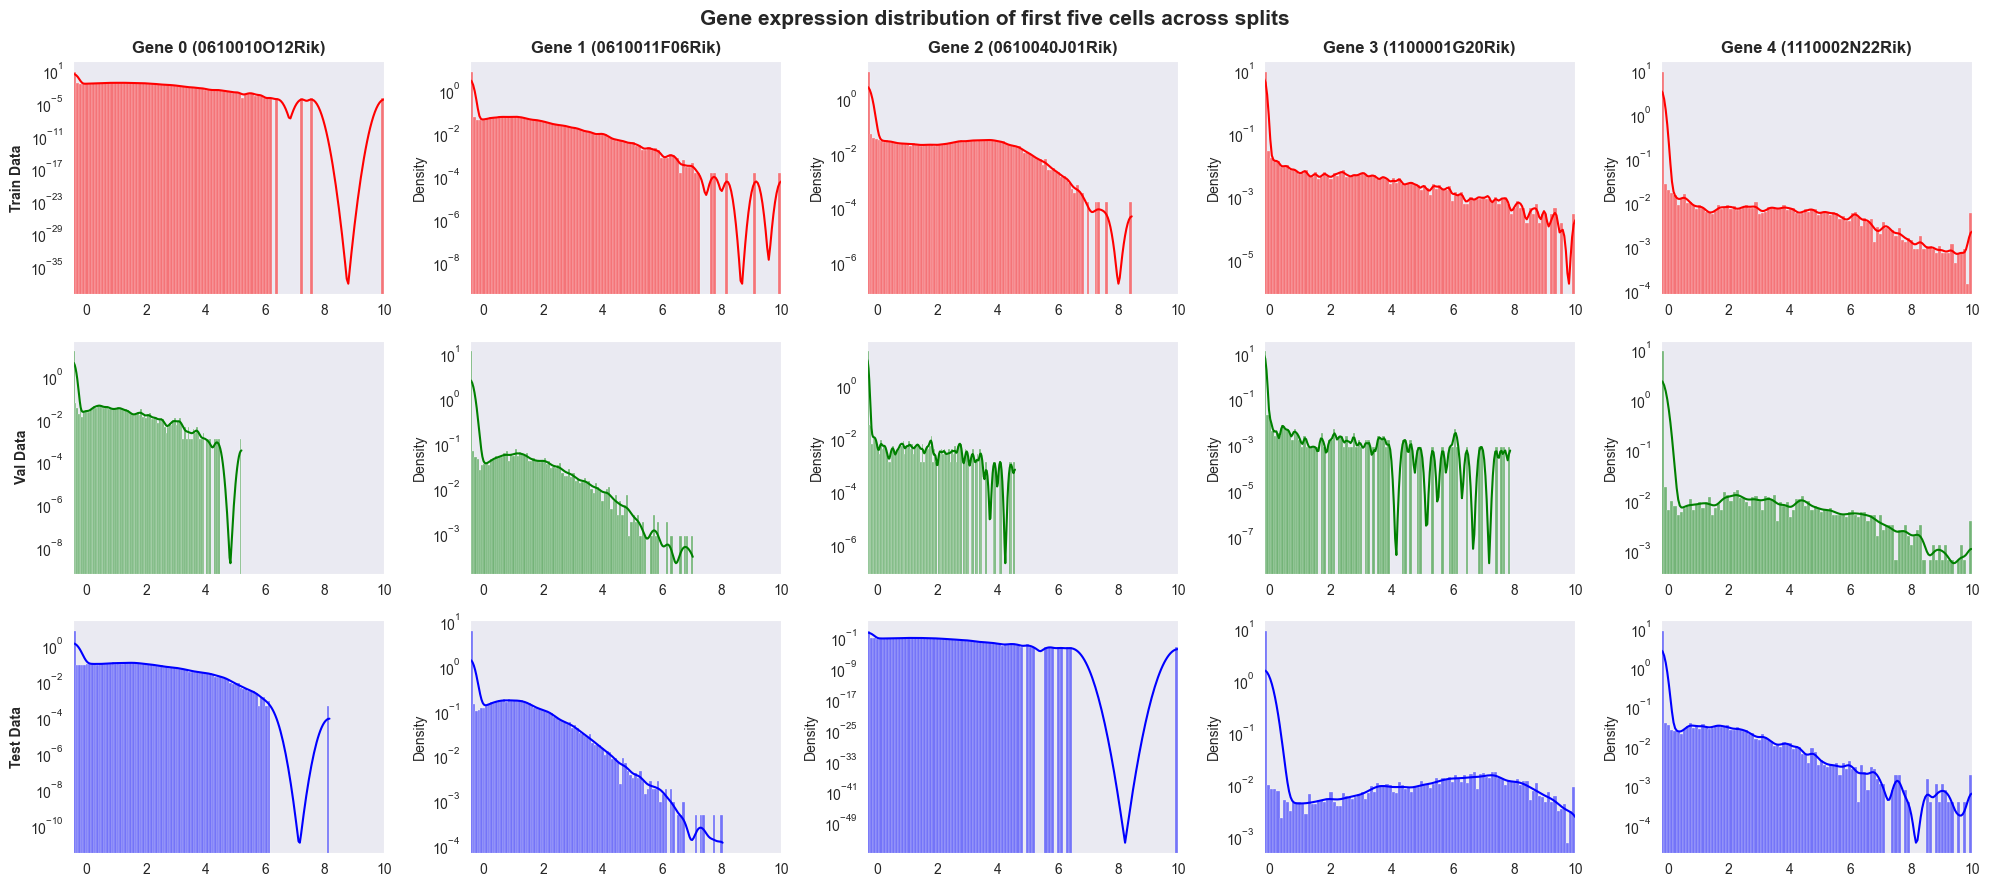

In [23]:
num_genes = 5  # Visualise the first five genes
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 9))

for j in range(num_genes):
    min_val, max_val = np.inf, -np.inf
    for i, data in enumerate([train_data, val_data, test_data]):
        # Get data of first five cells in split
        x = data.samples[:, :num_genes]

        xmin_val, xmax_val = x[:, j].min(), x[:, j].max()
        if xmin_val < min_val:
            min_val = xmin_val
        if xmax_val > max_val:
            max_val = xmax_val

        # Plot the first five genes
        sns.histplot(
            x=x[:, j],
            ax=axs[i, j],
            kde=True,
            bins=100,
            stat="density",
            color=["red", "green", "blue"][i],
        )

        axs[i, 0].set_ylabel(
            f"{data.mode.capitalize()} Data", fontweight="bold")

    # Set x-axis limits
    for i in range(3):
        axs[i, j].set_xlim(min_val, max_val)
        axs[i, j].set_yscale("log")

    axs[0, j].set_title(
        f"Gene {j} ({data.data.var.iloc[j].name})", fontweight="bold")


fig.suptitle(
    "Gene expression distribution of first five cells across splits",
    fontsize=15,
    fontweight="bold",
)
fig.tight_layout()

We visualise the gene expression distribution of the first five (out of 2866)
genes across the three splits using hisotgrams with overlayed kernel density
estimates and log the y-axis to better understand the tail of the distribution.
We can see that the gene expression distribution generally follows a
heavy-tailed distribution, with a few genes having very high expression values.
We can also see that the distribution are potentially different across the three
splits, which is expected as the splits represent cells from different tissues
and the cells were selected based on general variance in gene expression. One
would hope that similar differences are also present when plotting by cell type,
as such differences would be useful for classification.

> Most of these findings align with the pre-processing steps described in
> `data.utils.py` in the `preprocess` method. After filtering out samples and
> features (e.g. too little expressions for a cell, too little variance of a
> gene across cells), the data is a) log-transformed, b) zero-centered (and cut
> off at 10) and c) zero-imputed. Thus, the original data must have been even
> more heavy-tailed and sparse but now we observe zero-centered distribution
> with no missing values and a heavy-tail data is cut at 10.


**Tissue Distributions.** Let's now understand the target distribution of the
data. In this task, the label is the cell type
(`cell_ontology_class_reannotated`). To make this a suitable transfer/ few-shot
learning task the samples from the different splits originate from different
tissues (group of similar cvelles that work together to perform a specific
function). We can recover the original tissues, cell types and integer encoded
labels.


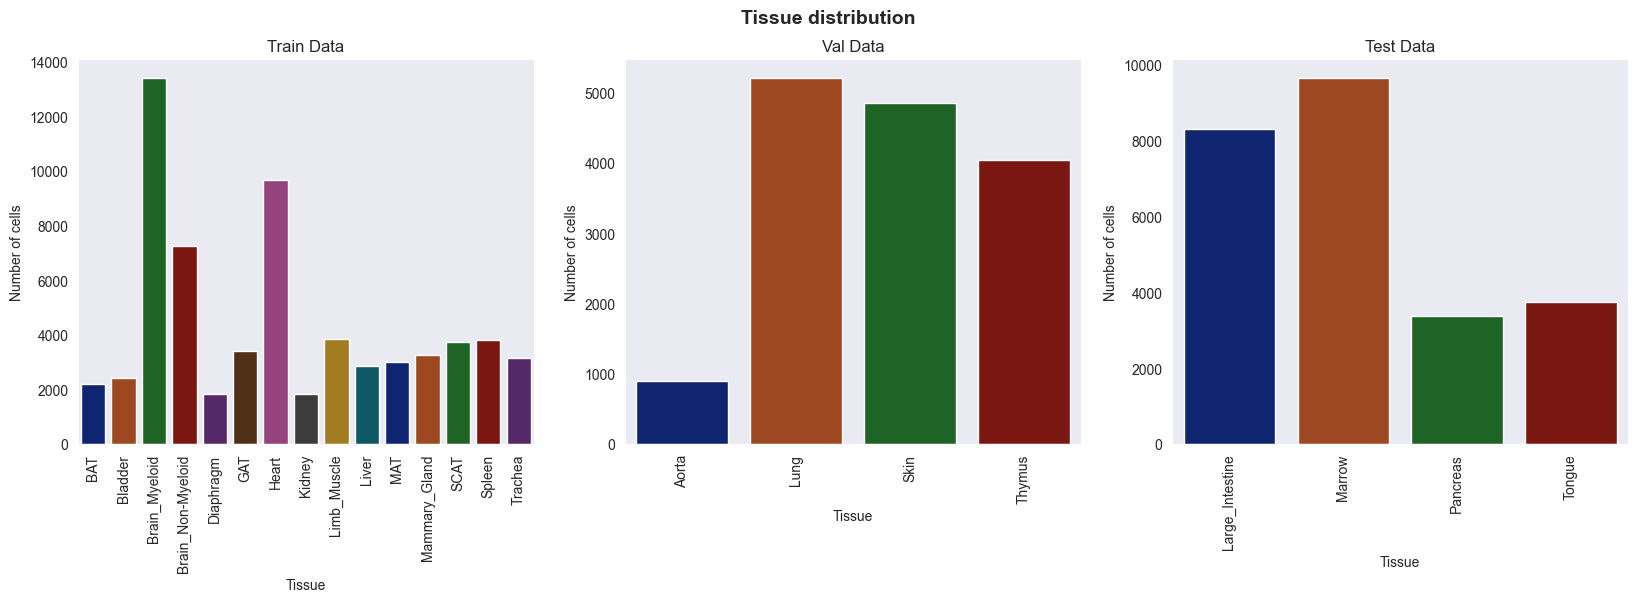

In [24]:
# Plot tissue distribution
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
fig.suptitle("Tissue distribution", fontsize=14, fontweight="bold")

for ax, data in zip(axs, [train_data, val_data, test_data]):
    tissues = data.data.obs.tissue.value_counts()
    ax = sns.barplot(x=tissues.index, y=tissues.values, palette="dark", ax=ax)

    ax.set(
        xlabel="Tissue",
        ylabel="Number of cells",
        title=f"{data.mode.capitalize()} Data",
    )
    # Rotate x-axis labels
    ax.tick_params(axis="x", rotation=90)

This aligns with the pre-processing that we set in the dataset class. There are
15 tissues in training and four in validation and test. Crucially, these are
disjoint, e.g. we will never have a cell from type `Lung` in our training. Let's
next look at the target distribution across the splits, which are the cell
types.

There are three different ways to obtain the label of a sample from the dataset:

1. In the `obs.cell_ontology_class_reannotated` column of the `AnnData` object
   (`data` attribute of the dataset class). This will be the string
   representation of the cell type.

2. In the `obs.label` column of the `AnnData` object (`data` attribute of the
   dataset class). This will be the integer representation of the cell type.

3. In the `target` attribute of the dataset class. This will be the integer
   representation that is specific to the split (e.g. does not match up with the
   integer representation of the `AnnData` object). It creates a new mapping {0,
   ..., n_classes-1} for all cell types that are present in the tissues of the
   split. Thus, the integer representation of the cell type cannot be compared
   across splits.


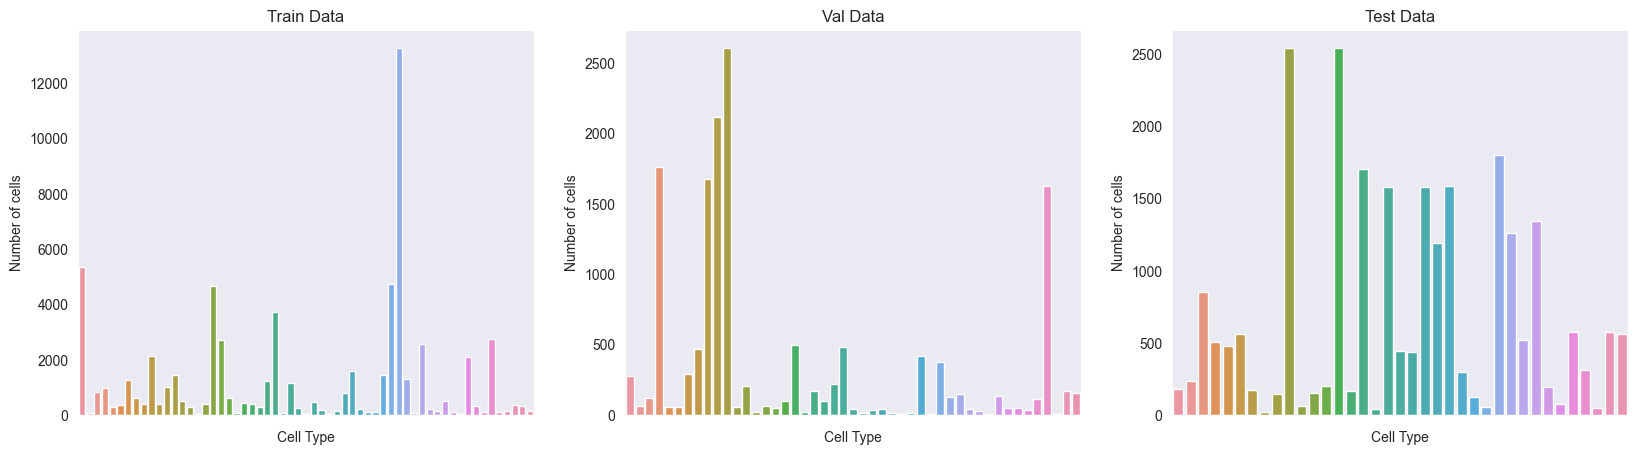

In [25]:
# Plot target distribution
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, data in zip(axs, [train_data, val_data, test_data]):
    labels_enc = data.data.obs.label.value_counts()
    sns.barplot(x=labels_enc.index, y=labels_enc.values, ax=ax)

    ax.set(
        xlabel="Cell Type",
        ylabel="Number of cells",
        title=f"{data.mode.capitalize()} Data",
    )
    ax.set_xticklabels([])

**Difficulty.** We can get an intuition for the difficulty of the few-shot
learning problem by looking at the samples per class within episodes.


In [26]:
def visualise_episodes(data, n_episodes, n_way, n_support, n_query):
    # Initialise data loader
    dataset = data(
        n_episodes=n_episodes,
        n_way=n_way,
        n_support=n_support,
        n_query=n_query,
        root="../data",
        mode="train",
    )
    loader = dataset.get_data_loader(num_workers=0, pin_memory=False)

    # Initialise transformers
    scaler = StandardScaler()
    pca = PCA(n_components=2)
    encoder = LabelEncoder()

    fig, ax = plt.subplots(ncols=n_episodes, figsize=(5 * n_episodes, 5))
    fig.tight_layout()
    for batch_idx, (x, y) in enumerate(loader):
        xs, xq = x[:, :n_support], x[:, n_support:]
        ys, yq = y[:, :n_support], y[:, n_support:]

        xs, ys = xs.reshape(-1, dataset.dim).numpy(), ys.reshape(-1).numpy()
        xq, yq = xq.reshape(-1, dataset.dim).numpy(), yq.reshape(-1).numpy()

        xs = scaler.fit_transform(xs)
        xq = scaler.transform(xq)

        xs = pca.fit_transform(xs)
        xq = pca.transform(xq)

        ys = encoder.fit_transform(ys)
        yq = encoder.transform(yq)

        sns.scatterplot(
            x=xs[:, 0],
            y=xs[:, 1],
            hue=ys,
            palette="dark",
            s=50,
            ax=ax[batch_idx],
        )
        sns.scatterplot(
            x=xq[:, 0],
            y=xq[:, 1],
            hue=yq,
            palette="dark",
            s=50,
            ax=ax[batch_idx],
        )
        ax[batch_idx].get_legend().remove()
        ax[batch_idx].set_xticklabels([])
        ax[batch_idx].set_yticklabels([])

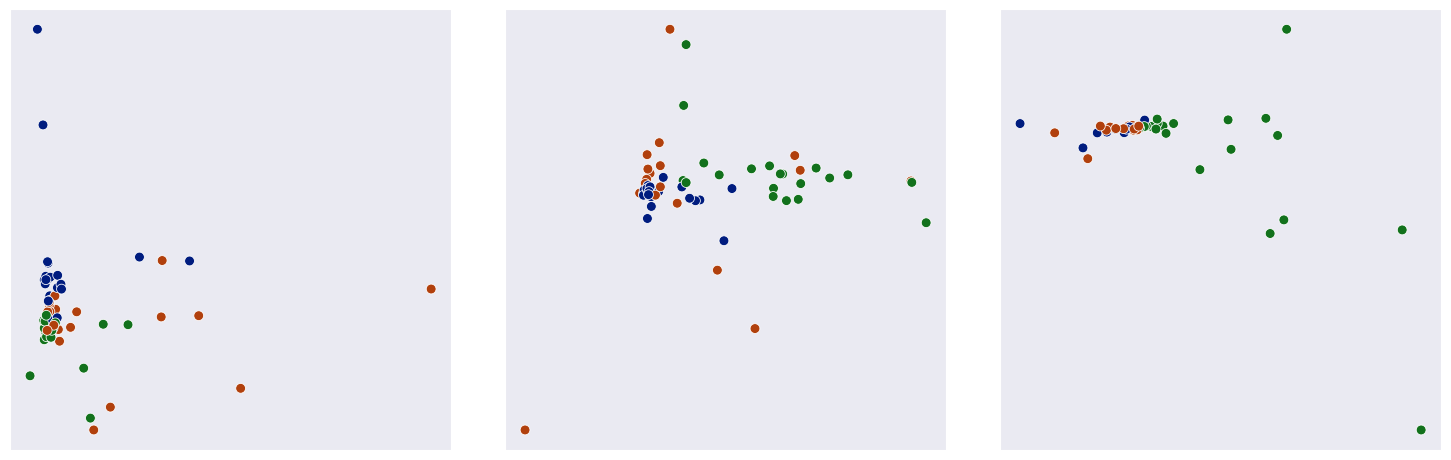

In [27]:
# Load data
n_episodes, n_way, n_support, n_query = 3, 3, 10, 10
visualise_episodes(
    TMSetDataset,
    n_episodes=n_episodes,
    n_way=n_way,
    n_support=n_support,
    n_query=n_query,
)

## SwissProt

---

SWISS-PROT is an annotated protein sequence database, which was created at the
Department of Medical Biochemistry of the University of Geneva (first started
1987). In SWISS-PROT two classes of data can be distinguished: the core data and
the annotation. For each sequence entry the core data consists of the sequence
data; the citation information (bibliographical references) and the taxonomic
data (description of the biological source of the protein), while the annotation
consists of the description of the following items:

- Function(s) of the protein
- Post-translational modification(s). For example carbohydrates,
  phosphorylation, acetylation, GPI-anchor, etc.
- Domains and sites. For example calcium binding regions, ATP-binding sites,
  zinc fingers, homeoboxes, SH2 and SH3 domains, etc.
- Secondary structure. For example alpha helix, beta sheet, etc.
- Quaternary structure. For example homodimer, heterotrimer, etc.
- Similarities to other proteins
- Disease(s) associated with deficiencie(s) in the protein
- Sequence conflicts, variants, etc.

Within this project we will focus on the function annotation of proteins, thus
given the protein sequence (string of amino acids) we want to predict the
function of the protein.

_More Resources_:

- [National Library of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC102476/)


### SPSimpleDataset

The `SPSimpleDataset` is a simple dataset class that is designed for regular
multi-class classification training/ fine-tuning. It loads the entire
(processed) dataset into memory and wraps inside a PyTorch Dataset object.
Supports functionality for retrieving a single sample, a batched data loader and
the dimensionality of the data.


In [ ]:
# The data has to be manually downloaded to this folder
!du -sh ../data/swissprot/*

In [ ]:
# Demo: TMSetDataset
from datasets.prot.swissprot import SPSimpleDataset  # noqa

# Arguments to provide
root = "../data"
batch_size = 10
min_samples = 1

kwargs = {
    "root": root,
    "batch_size": batch_size,
    "min_samples": min_samples,
}

# Show loading time for each split
modes = ["train", "val", "test"]
for mode in modes:
    start = time.time()
    SPSimpleDataset(**kwargs, mode=mode)
    print(f"✅ SwissProt {mode} split loaded in {time.time() - start:.2f} seconds.")

In [ ]:
# This asssumes the data is downloaded manually
!du -sh ../data/swissprot/processed*

Nice, we can load the data fast and easy. The class also supports subsetting
which is useful for debugging the training. However, because we are still
loading all the data into memory before subsetting, we do not get any speed up
(_NB: We could decide to save and load splitted data to disk, but this is not
implemented yet_).

**NB:** The SwissProt dataset as-is is relatively small and can be loaded into
memory without many problems. In this case, subsetting the data decreases the
number of classes that are included according to our specification of the
minimum number of classes and is therefore generally not advised.


Let's load the full training split again and do some exploratory data analysis.


In [ ]:
# Demo: SPSimpleDataset
train_data = SPSimpleDataset(**kwargs, mode="train")
val_data = SPSimpleDataset(**kwargs, mode="val")
test_data = SPSimpleDataset(**kwargs, mode="test")

In [ ]:
from datasets.prot.utils import get_samples_using_ic  # noqa

sp = get_samples_using_ic("../data/swissprot")

In [ ]:
np.unique([s.annot for s in sp])

Let's compute some basic dataset statistics for each split.


In [ ]:
# Compute number of samples
print(f"ℹ️ SwissProt train split has {len(train_data)} samples")
print(f"ℹ️ SwissProt val split has {len(val_data)} samples")
print(f"ℹ️ SwissProt test split has {len(test_data)} samples\n")

# Compute dimension of samples
assert train_data.dim == val_data.dim == test_data.dim, "❌ Dimensions are not equal."
print(
    f"ℹ️ Each sample (in all splits) is an encoded protein sequence of length {train_data.dim}\n"
)

# Compute number of classes
train_classes = set([s.annot for s in train_data.samples])
val_classes = set([s.annot for s in val_data.samples])
test_classes = set([s.annot for s in test_data.samples])

print(
    f"ℹ️ SwissProt train split has {len(train_classes)} classes ({list(train_classes)[:5]})"
)
print(
    f"ℹ️ SwissProt val split has {len(val_classes)} classes ({list(val_classes)[:5]})"
)
print(
    f"ℹ️ SwissProt test split has {len(test_classes)} classes ({list(test_classes)[:5]})"
)

Let's try to understand the relationship between the targets across the splits.


In [ ]:
# Total classes (union)
all_classes = train_classes | val_classes | test_classes
print(
    f"ℹ️ SwissProt has {len(all_classes)} unique classes ({list(all_classes)[:5]}, ...) in total."
)

# Total shared classes (intersection)
print(
    f"ℹ️ SwissProt has {len(train_classes & val_classes & test_classes)} shared classes ({train_classes & val_classes & test_classes}) in total."
)
print(
    f"ℹ️ SwissProt has {len(train_classes & val_classes)} shared classes between train and val."
)
print(
    f"ℹ️ SwissProt has {len(train_classes & test_classes)} shared classes between train and test."
)

Let's understand the integer-encoding of the protein sequences.


In [ ]:
# Get encoded classes
train_classes_enc = set([y for _, y in train_data])
val_classes_enc = set([y for _, y in val_data])
test_classes_enc = set([y for _, y in test_data])

# Total classes (union)
all_classes = train_classes_enc | val_classes_enc | test_classes_enc
print(
    f"ℹ️ SwissProt has {len(all_classes)} unique classes ({list(all_classes)[:5]}, ...) in total."
)

# Total shared classes (intersection)
print(
    f"ℹ️ SwissProt has {len(train_classes_enc & val_classes_enc & test_classes_enc)} shared classes in total."
)
print(
    f"ℹ️ SwissProt has {len(train_classes_enc & val_classes_enc)} shared classes between train and val."
)
print(
    f"ℹ️ SwissProt has {len(train_classes_enc & test_classes_enc)} shared classes between train and test."
)

It looks like the encoding is global here as there is no overlap between the
encoded classes in the splits (if another encoding from {0, ..., K-1}, then
there should be overlap).


Let's visualise the class distribution in all splits.


In [ ]:
# Class distribution
fig, axs = plt.subplots(nrows=3, figsize=(20, 10))

for ax, data in zip(axs, [train_data, val_data, test_data]):
    classes = [y for _, y in data]
    sns.countplot(x=classes, ax=ax)

    ax.set(
        xlabel="Class",
        ylabel="Number of samples",
        title=f"{data.mode.capitalize()} Data",
    )
    if ax == axs[0]:
        ax.set_xticklabels([])

fig.tight_layout()

We can see that the class distribution is highly imbalanced. Both the number of
of classes as well as the number of samples within each of these classes varies
greatly.

Let's now investigate the protein encodings that we are given.


In [ ]:
from sklearn.decomposition import PCA

num_classes = 5
max_num_samples = 100

# Extract the included labels (protein functions) in the splits
train_most_common = Counter([y for _, y in train_data]).most_common(num_classes)
val_most_common = Counter([y for _, y in val_data]).most_common(num_classes)
test_most_common = Counter([y for _, y in test_data]).most_common(num_classes)

train_include_classes = [y for y, _ in train_most_common]
val_include_classes = [y for y, _ in val_most_common]
test_include_classes = [y for y, _ in test_most_common]

min_num_samples = min(
    min([c for _, c in train_most_common]),
    min([c for _, c in val_most_common]),
    min([c for _, c in test_most_common]),
)

num_samples = min(min_num_samples, max_num_samples)

print(f"Showing {num_samples} samples per class.")

# Filter the samples by the included labels and choose the first num_samples
train_samples = []
for yi in train_include_classes:
    train_samples.append(
        [x.tolist() + [y] for x, y in train_data if y == yi][:min_num_samples]
    )
train_samples = np.array(train_samples).reshape(-1, 1281)

val_samples = []
for yi in val_include_classes:
    val_samples.append(
        [x.tolist() + [y] for x, y in val_data if y == yi][:min_num_samples]
    )
val_samples = np.array(val_samples).reshape(-1, 1281)

test_samples = []
for yi in test_include_classes:
    test_samples.append(
        [x.tolist() + [y] for x, y in test_data if y == yi][:min_num_samples]
    )
test_samples = np.array(test_samples).reshape(-1, 1281)

train_X, train_y = train_samples[:, :-1], train_samples[:, -1]
val_X, val_y = val_samples[:, :-1], val_samples[:, -1]
test_X, test_y = test_samples[:, :-1], test_samples[:, -1]

pca = PCA(n_components=2)

train_pca_samples = pca.fit_transform(train_X)
val_pca_samples = pca.fit_transform(val_X)
test_pca_samples = pca.fit_transform(test_X)

fig, axs = plt.subplots(ncols=3, figsize=(18, 6))

samples = [train_pca_samples, val_pca_samples, test_pca_samples]
targets = [train_y, val_y, test_y]
for i in range(3):
    sns.scatterplot(
        x=samples[i][:, 0],
        y=samples[i][:, 1],
        hue=targets[i],
        palette="Paired",
        ax=axs[i],
    )
    axs[i].set(
        xlabel="PC1",
        ylabel="PC2",
    )

In [ ]:
from datasets.prot.swissprot import SPSetDataset  # noqa
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Load data
n_episodes = 5
palette = "brg"
n_way, n_support, n_query = 5, 20, 5
data = SPSetDataset(
    root="../data",
    n_way=n_way,
    n_support=n_support,
    n_query=n_query,
    n_episodes=n_episodes,
    mode="train",
)
loader = data.get_data_loader(num_workers=0, pin_memory=False)

sc = StandardScaler()
dr = PCA(n_components=2)
le = LabelEncoder()

fig, ax = plt.subplots(ncols=n_episodes, figsize=(5 * n_episodes, 5))
fig.suptitle(
    f"SwissProt {n_episodes} Episodes ({n_way}-way, {n_support}-shot, {n_query}-query)",
    fontsize=15,
    fontweight="bold",
)
for batch_idx, (x, y) in enumerate(loader):
    xs, xq = x[:, :n_support], x[:, n_support:]
    ys, yq = y[:, :n_support], y[:, n_support:]

    xs, ys = xs.reshape(-1, 1280).numpy(), ys.reshape(-1).numpy()
    xq, yq = xq.reshape(-1, 1280).numpy(), yq.reshape(-1).numpy()

    xs = sc.fit_transform(xs)
    xq = sc.transform(xq)

    xs = dr.fit_transform(xs)
    xq = dr.transform(xq)

    ys = le.fit_transform(ys)
    yq = le.transform(yq)

    sns.regplot(
        x=xs[:, 0],
        y=xs[:, 1],
        hue=ys,
        palette=palette,
        s=50,
        ax=ax[batch_idx],
    )
    sns.regplot(
        x=xq[:, 0],
        y=xq[:, 1],
        hue=yq,
        palette=palette,
        s=50,
        ax=ax[batch_idx],
    )
    ax[batch_idx].get_legend().remove()
    ax[batch_idx].set_xticklabels([])
    ax[batch_idx].set_yticklabels([])

In [ ]:
# Compute PCA on standardised data
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2)
xt = pca.fit_transform(scaler.fit_transform(x))

# Label encoding
le = LabelEncoder()
yt = le.fit_transform(y)

print(xt.shape, yt.shape)

In [ ]:
# Plot PCA
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=xt[:, 0], y=xt[:, 1], hue=yt,
                palette="Set3", alpha=0.8, ax=ax)
ax.get_legend().remove()

There are two types of constraints:

- `n_way`: We can never test on more classes than we available in the split with
  the least amount of classes (typically the test split)
- `min_samples` (`n_support` and `n_query`): We cannot test on classes that
  don't have at least `n_support + n_query` samples available.

We are dynamically adjusting the `min_samples` dataset. However, this will
reduce the number of classes that are available. Thus, we dynamically check if
for a given configuration of `n_support`, `n_query` and `n_way` we can actually
create a valid dataset in the main script.


In [ ]:
for min_samples in range(2, 11):
    kwargs["min_samples"] = min_samples
    test_data = SPSimpleDataset(**kwargs, mode="test")

    # Compute number of classes
    print(
        f"ℹ️ With min_samples={min_samples}, we can support n_way <= {len(set([s.annot for s in test_data.samples]))}"
    )

We can get a single sample by indexing the dataset.


In [ ]:
# Sample by indexing
x, y = data[0]

print(f"Training sample (encoded protein sequence): {x.shape} and target {y}")

And we can get a regular batch by using the data loader returned by the
`get_data_loader` method.


In [ ]:
# Sample using data loader (use pin_memory=True if using GPU)
data_loader = data.get_data_loader(num_workers=0, pin_memory=False)

# Create iterator
data_iter = iter(data_loader)

# Get five batches
for batch_idx in range(5):
    xb, yb = next(data_iter)
    print(f"Batch {batch_idx+1} Sequence: {xb.shape} and target {yb}")

### SPSetDataset

The `SPSetDataset` is designed for few-shot learning. Most configurations are
the same as for the `SPSimpleDataset`, but crucially the dataset class will
return an episodic batch sampler based on the `n_way`, `n_support`, `n_query`
and parameters.


In [ ]:
# Demo: TMSetDataset
from datasets.prot.swissprot import SPSetDataset  # noqa

# Arguments to provide
root = "../data"
n_way = 5
n_support = 3
n_query = 3
subset = 1.0

kwargs = {
    "n_way": n_way,
    "n_support": n_support,
    "n_query": n_query,
    "root": root,
    "subset": subset,
}

modes = ["train", "val", "test"]
for mode in modes:
    start = time.time()
    data = SPSetDataset(**kwargs, mode=mode)
    print(
        f"✅ SPSetDataset {mode} split ({len(data)} class data loaders) loaded in {time.time() - start:.2f} seconds."
    )

Let's load the full training split again and do some exploratory data analysis.


In [ ]:
# Demo: SPSetDataset
data = SPSetDataset(**kwargs, mode="train")

In [ ]:
# Get some basic statistics
num_samples = len(data)
dim = data.dim

print(f"ℹ️ SwissProt train split has {len(data)} classes")
print(f"ℹ️ Each sample is an encoded protein sequence of length {dim}")

Again, in few-shot learning a single "sample" is defined not as the feature
vector, target tuple but as a set of support and query samples within a class.
Thus, the `__getitem__` method returns a tuple of the support and query samples
and targets for the `i`-th class. Thus, the returned tensor dimension will be
`(n_support + n_query, n_features)` for the samples and
`(n_support + n_query, )` for the targets.


In [ ]:
# Sample by indexing
x, y = data[0]

print(
    f"Training sample (encoded protein sequence): feature shape {x.shape} and target shape {y.shape}"
)

Next, the data loader class combines the support-query sampler per class (as
defined above) and the `EpisodicBatchSampler` to create a data loader that
returns batches of episodes where each time we get `n_way` classes with
`n_support` support samples and `n_query` query samples per class. First, the
episodic batch sample samples the `n_way` random class indices and then the
support-query sampler samples the support and query samples for each class.
Thus, the final tensor shapes will be `(n_way, n_query + n_support, n_features)`
for the samples and `(n_way, n_query + n_support, )` for the targets.


In [ ]:
# Sample using data loader (use pin_memory=True if using GPU)
data_loader = data.get_data_loader(num_workers=0, pin_memory=False)

# Get one batches
xb, yb = next(iter(data_loader))
print(f"Batch {batch_idx+1} Sequence: {xb.shape} and target {yb.shape}")
print("Target")
print(yb)